In [5]:
import time
import base64
from IPython.display import Image, display

from hypha_rpc import connect_to_server,login
import os
import asyncio
import dotenv

dotenv.load_dotenv()  
ENV_FILE = dotenv.find_dotenv()  
if ENV_FILE:  
    dotenv.load_dotenv(ENV_FILE)  

server_url = "https://hypha.aicell.io"

reef_token = os.environ.get("REEF_WORKSPACE_TOKEN")
squid_token = os.environ.get("SQUID_WORKSPACE_TOKEN")

if not reef_token or not squid_token:
    token = await login({"server_url": server_url})
    reef_token = token
    squid_token = token
reef_server = await connect_to_server({"server_url": server_url, "token": reef_token, "workspace": "reef-imaging", "ping_interval": None})
squid_server = await connect_to_server({"server_url": server_url, "token": squid_token, "workspace": "squid-control", "ping_interval": None})


incubator_id = "incubator-control"
microscope_id = "microscope-control-squid-real-microscope-reef"
robotic_arm_id = "robotic-arm-control"

incubator = await reef_server.get_service(incubator_id)
microscope = await squid_server.get_service(microscope_id)
robotic_arm = await reef_server.get_service(robotic_arm_id)
print('connected')

connected


In [ ]:
import asyncio
await incubator.initialize()
while await incubator.is_busy():
    await asyncio.sleep(1)

In [6]:
await microscope.home_stage()

'The stage moved to home position in z, y, and x axis'

In [7]:
await microscope.return_stage()

'The stage moved to the initial position'

In [9]:
await microscope.navigate_to_well('A',1,wellplate_type="96")
image = await microscope.snap(exposure_time=28,channel=0,intensity=10)
print(image)

https://hypha.aicell.io/squid-control/apps/data-store-real-microscope/get?id=1cf24b9b-aba9-4741-bccd-85a0dbe49cbe


In [13]:
await microscope.do_laser_autofocus()

'The camera is auto-focused'

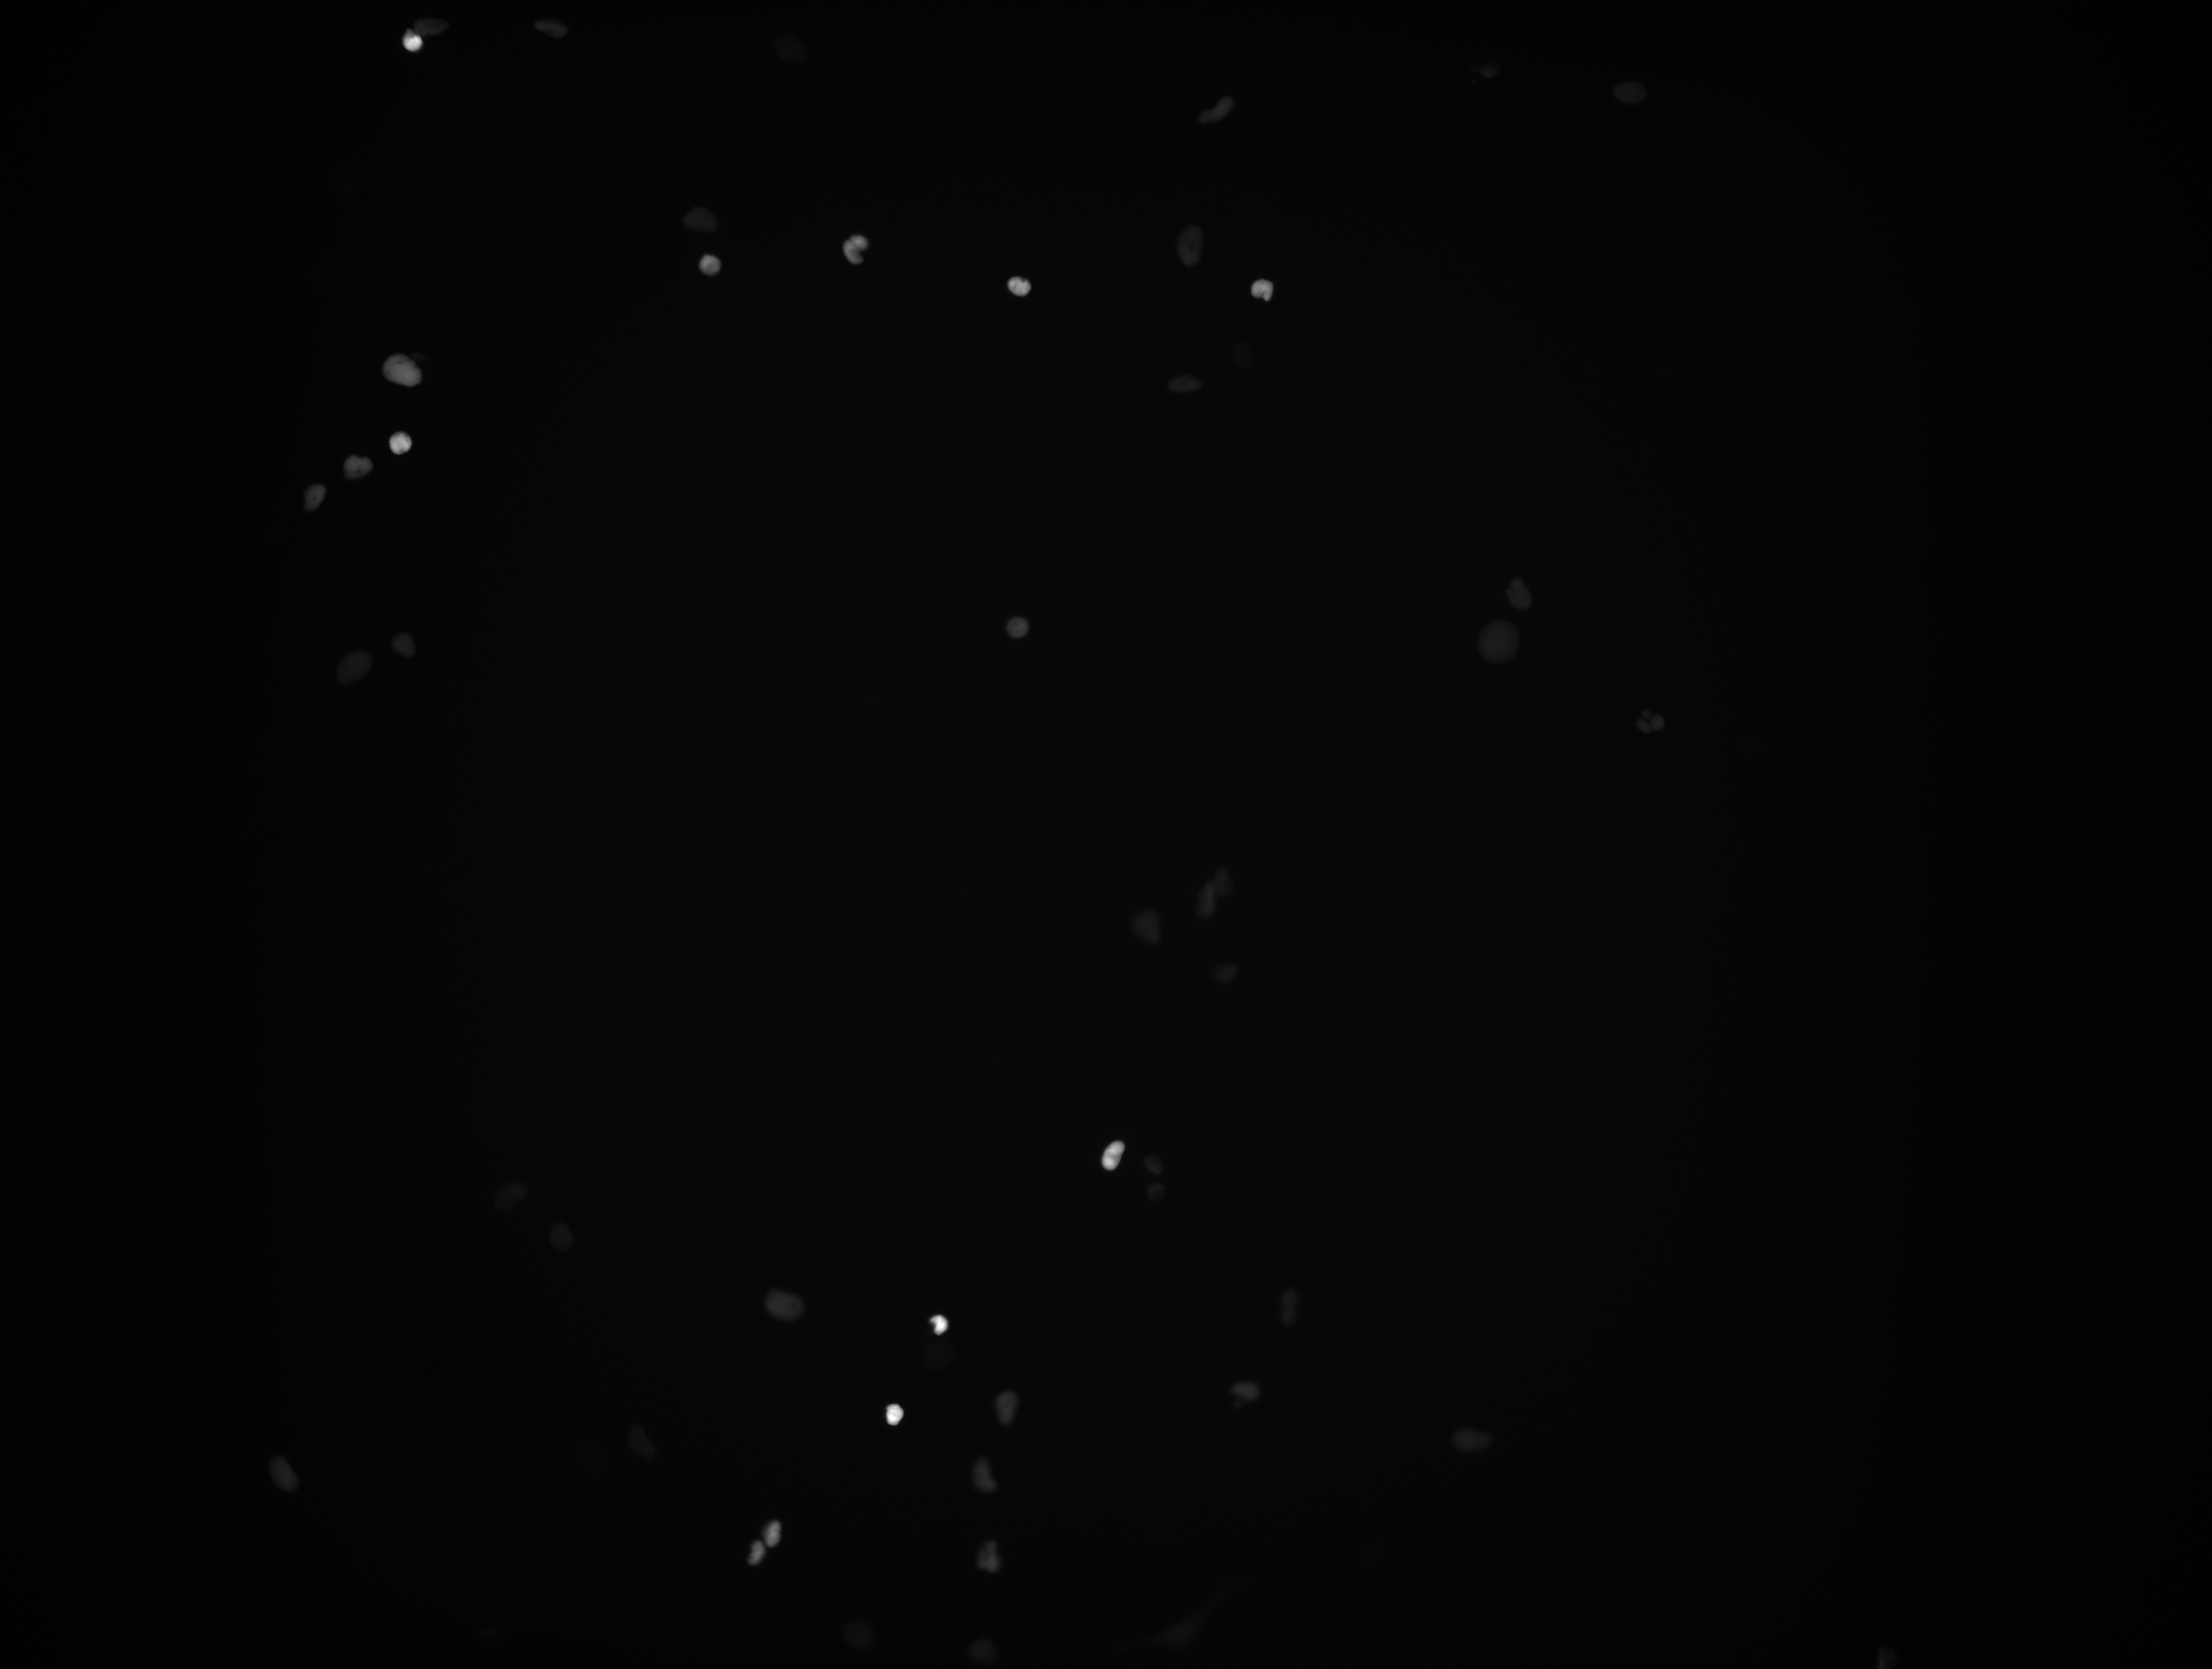

In [14]:
image_base64 = await microscope.one_new_frame(exposure_time=100, channel=14, intensity=98)
img_data = base64.b64decode(image_base64)
display(Image(data=img_data))

In [ ]:
## Any time you want to stop the robotic arm, you can run 'halt'
await robotic_arm.connect()
await robotic_arm.halt()


In [8]:

sample_loaded = False

async def check_sample_loaded():
    global sample_loaded
    if sample_loaded:
        print("Sample plate has already been loaded onto the microscope")
    else:
        print("Sample plate is not loaded yet")

    return sample_loaded

async def load_plate_from_incubator_to_microscope(incubator_slot=33):
    """Load plate from incubator onto microscope."""
    global sample_loaded
    assert not sample_loaded, "Sample plate has already been loaded"
    await incubator.get_sample_from_slot_to_transfer_station(incubator_slot)
    await microscope.home_stage()
    print("Plate loaded onto station.")
    await robotic_arm.connect()
    print("Robotic arm connected.")
    await robotic_arm.grab_sample_from_incubator()
    print("Sample grabbed.")
    await robotic_arm.transport_from_incubator_to_microscope1()
    print("Sample transported.")
    await robotic_arm.put_sample_on_microscope1()
    print("Sample placed on microscope.")
    await robotic_arm.disconnect()
    print("Robotic arm disconnected.")
    await microscope.return_stage()
    print("Sample plate successfully loaded onto microscope stage.")
    sample_loaded = True

async def unload_plate_from_microscope(incubator_slot=33):
    global sample_loaded
    assert sample_loaded, "Sample plate is not on the microscope"
    await robotic_arm.connect()
    # Move sample from microscope to incubator
    await microscope.home_stage()
    print("microscope homed.")
    await robotic_arm.grab_sample_from_microscope1()
    print("Sample grabbed from microscope.")
    await robotic_arm.transport_from_microscope1_to_incubator()
    print("Sample moved to incubator.")
    await robotic_arm.put_sample_on_incubator()
    print("Sample placed on incubator.")

    
    await incubator.put_sample_from_transfer_station_to_slot(incubator_slot)
    print("Sample moved to incubator.")
    await microscope.return_stage()

    await robotic_arm.disconnect()
    print("Sample successfully unloaded from the microscopy stage")
    sample_loaded = False


In [9]:
await load_plate_from_incubator_to_microscope(incubator_slot=33)

Plate loaded onto station.
Robotic arm connected.
Sample grabbed.
Sample transported.
Sample placed on microscope.
Robotic arm disconnected.
Sample plate successfully loaded onto microscope stage.


In [10]:
await microscope.scan_well_plate(illuminate_channels=['BF LED matrix full','Fluorescence 488 nm Ex','Fluorescence 561 nm Ex'],do_reflection_af=True,scanning_zone=[(0,0),(7,11)], action_ID='testPlateScan')
#note: the imaging data will be saved
# n local harddisk

'Well plate scanning completed'

In [11]:
await unload_plate_from_microscope()

microscope homed.
Sample grabbed from microscope.
Sample moved to incubator.
Sample placed on incubator.
Sample moved to incubator.
Sample successfully unloaded from the microscopy stage
